# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [2]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)
data = pandas.read_csv('preprocessed_data.csv')

project_data = data.sample(n = 100000) 

project_data.shape

(100000, 9)

In [3]:
df = pd.read_csv('train_data.csv')
df.shape

(109248, 17)

In [4]:
## taking random samples of 100k datapoints
project_data = data.sample(n = 100000) 
project_data.shape

(100000, 9)

###  Pre-Processing of Project Titles

In [5]:
# https://stackoverflow.com/a/47091490/4084039

import re
def deconstructed(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [7]:
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(df['project_title'].values):
    sent = deconstructed(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:08<00:00, 12339.74it/s]


In [8]:
project_data['preprocessed_titles'] = preprocessed_titles[:100000]

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

In [9]:
project_data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,preprocessed_titles
108970,ca,ms,grades_3_5,30,1,literacy_language math_science,literature_writing mathematics,our little school proud energetic positive 5th...,169.00,educational support english learners home
22017,nd,mrs,grades_prek_2,4,1,health_sports,gym_fitness health_wellness,my students creative eager active 6 7 year old...,512.56,wanted projector hungry learners
60588,ca,mrs,grades_prek_2,13,1,warmth care_hunger,warmth care_hunger,my first graders live described food dessert t...,376.79,soccer equipment awesome middle school students
61141,ny,ms,grades_prek_2,23,1,appliedlearning,earlydevelopment other,i kindergarten teacher 26 students yearn learn...,86.15,techie kindergarteners
27305,tx,mrs,grades_prek_2,11,1,health_sports,gym_fitness health_wellness,our school socioeconomically disadvantaged sch...,279.66,interactive math tools


In [10]:
projects_approved_counts = project_data['project_is_approved'].value_counts()
print("Number of projects approved and not approved counts",projects_approved_counts)

print("Number of projects thar are approved for funding:", projects_approved_counts[1]," -> ",round(projects_approved_counts[1]/(projects_approved_counts[1]+projects_approved_counts[0])*100,2),"%")
print("Number of projects thar are not approved for funding: ", projects_approved_counts[0]," -> ",round(projects_approved_counts[0]/(projects_approved_counts[1]+projects_approved_counts[0])*100,2),"%")


Number of projects approved and not approved counts 1    84923
0    15077
Name: project_is_approved, dtype: int64
Number of projects thar are approved for funding: 84923  ->  84.92 %
Number of projects thar are not approved for funding:  15077  ->  15.08 %


In [11]:
# Split the dataset 
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(
    project_data,
    project_data['project_is_approved'],
    test_size=0.2,
    random_state=42,
    stratify=project_data[['project_is_approved']])

print("x_train: ",x_train.shape)
print("x_test : ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test : ",y_test.shape)

x_train:  (80000, 10)
x_test :  (20000, 10)
y_train:  (80000,)
y_test :  (20000,)


In [12]:
print("X_TRAIN-------------------------")
x_train_y_value_counts = x_train['project_is_approved'].value_counts()
print("Number of projects that are approved for funding    ", x_train_y_value_counts[1]," -> ",round(x_train_y_value_counts[1]/(x_train_y_value_counts[1]+x_train_y_value_counts[0])*100,2),"%")
print("Number of projects that are not approved for funding ",x_train_y_value_counts[0]," -> ",round(x_train_y_value_counts[0]/(x_train_y_value_counts[1]+x_train_y_value_counts[0])*100,2),"%")
print("\n")

#y_value_counts = row1['project_is_approved'].value_counts()
print("X_TEST--------------------------")
x_test_y_value_counts = x_test['project_is_approved'].value_counts()
print("Number of projects that are approved for funding    ", x_test_y_value_counts[1]," -> ",round(x_test_y_value_counts[1]/(x_test_y_value_counts[1]+x_test_y_value_counts[0])*100,2),"%")
print("Number of projects that are not approved for funding ",x_test_y_value_counts[0]," -> ",round(x_test_y_value_counts[0]/(x_test_y_value_counts[1]+x_test_y_value_counts[0])*100,2),"%")
print("\n")

X_TRAIN-------------------------
Number of projects that are approved for funding     67938  ->  84.92 %
Number of projects that are not approved for funding  12062  ->  15.08 %


X_TEST--------------------------
Number of projects that are approved for funding     16985  ->  84.92 %
Number of projects that are not approved for funding  3015  ->  15.08 %




<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

Vectorize text data : Bag of words

In [13]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer_essay_bow = CountVectorizer(min_df=10,max_features=20000)

vectorizer_essay_bow.fit(x_train['essay'])

x_train_essays_bow = vectorizer_essay_bow.transform(x_train['essay'])
x_test_essays_bow  = vectorizer_essay_bow.transform(x_test['essay'])

print("Shape of matrix after BOW -> Essays: x_train: ",x_train_essays_bow.shape)
print("Shape of matrix after BOW -> Essays: x_test : ",x_test_essays_bow.shape)


Shape of matrix after BOW -> Essays: x_train:  (80000, 14722)
Shape of matrix after BOW -> Essays: x_test :  (20000, 14722)


In [14]:
vectorizer_title_bow = CountVectorizer(min_df=10,max_features=20000)

vectorizer_title_bow.fit(x_train['preprocessed_titles'])

x_train_titles_bow = vectorizer_title_bow.transform(x_train['preprocessed_titles'])
# x_cv_titles_bow    = vectorizer_title_bow.transform(x_cv['preprocessed_titles'])
x_test_titles_bow  = vectorizer_title_bow.transform(x_test['preprocessed_titles'])

print("Shape of matrix after BOW -> Title: x_train: ",x_train_titles_bow.shape)
# print("Shape of matrix after BOW -> Title: x_cv   : ",x_cv_titles_bow.shape)
print("Shape of matrix after BOW -> Title: x_test : ",x_test_titles_bow.shape)

Shape of matrix after BOW -> Title: x_train:  (80000, 2764)
Shape of matrix after BOW -> Title: x_test :  (20000, 2764)


Vectorize text data: TFIDF vectorizer

In [15]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10,max_features=20000)

vectorizer_essay_tfidf.fit(x_train['essay'])

x_train_essays_tfidf = vectorizer_essay_tfidf.transform(x_train['essay'])
x_test_essays_tfidf  = vectorizer_essay_tfidf.transform(x_test['essay'])

print("Shape of matrix after TF-IDF -> Essay: x_train: ",x_train_essays_tfidf.shape)
print("Shape of matrix after TF-IDF -> Essay: x_test : ",x_test_essays_tfidf.shape)

Shape of matrix after TF-IDF -> Essay: x_train:  (80000, 14722)
Shape of matrix after TF-IDF -> Essay: x_test :  (20000, 14722)


In [16]:
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_title_tfidf = TfidfVectorizer(min_df=10,max_features=20000)

vectorizer_title_tfidf.fit(x_train['preprocessed_titles'])

x_train_titles_tfidf = vectorizer_title_tfidf.transform(x_train['preprocessed_titles'])
x_test_titles_tfidf  = vectorizer_title_tfidf.transform(x_test['preprocessed_titles'])

print("Shape of matrix after TF-IDF -> Title: x_train: ",x_train_titles_tfidf.shape)
print("Shape of matrix after TF-IDF -> Title: x_test : ",x_test_titles_tfidf.shape)


Shape of matrix after TF-IDF -> Title: x_train:  (80000, 2764)
Shape of matrix after TF-IDF -> Title: x_test :  (20000, 2764)


# 

Preprocessing: Project Subject Categories 

In [17]:
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
print("done")


done


Preprocessing: Project Subject Sub Categories

In [18]:
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
print(sub_cat_dict)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))
print("done")



{'literature_writing': 20280, 'mathematics': 25638, 'gym_fitness': 4157, 'health_wellness': 9368, 'warmth': 1264, 'care_hunger': 1264, 'earlydevelopment': 3898, 'other': 2207, 'literacy': 30808, 'specialneeds': 12527, 'visualarts': 5731, 'teamsports': 2008, 'appliedsciences': 9907, 'esl': 3991, 'socialsciences': 1754, 'environmentalscience': 5162, 'nutritioneducation': 1240, 'history_geography': 2911, 'civics_government': 730, 'music': 2888, 'performingarts': 1801, 'college_careerprep': 2361, 'charactereducation': 1874, 'health_lifescience': 3904, 'foreignlanguages': 806, 'economics': 255, 'financialliteracy': 523, 'extracurricular': 759, 'parentinvolvement': 623, 'communityservice': 407}
done


Preprocessing: Project Grade Category

In [19]:
# this code removes " " and "-". ie Grades 3-5 -> grage3to5

clean_grades=[]
for project_grade in project_data['project_grade_category'].values:
    project_grade=str(project_grade).lower().strip().replace(' ','').replace('-','to')
    
    clean_grades.append(project_grade.strip())

project_data['clean_project_grade_category']=clean_grades
project_data.drop(['project_grade_category'],axis=1,inplace=True)

my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())
    
grade_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))
print("done")

done


# Vectorizing Categorical data: Clean Subject Categories

In [20]:
# we use count vectorizer to convert the values into one

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_sub_cat = CountVectorizer(vocabulary= list(sorted_cat_dict.keys()), lowercase=False, binary=True)

vectorizer_sub_cat.fit(x_train['clean_categories'].values)

x_train_categories_one_hot = vectorizer_sub_cat.transform(x_train['clean_categories'].values)
x_test_categories_one_hot  = vectorizer_sub_cat.transform(x_test['clean_categories'].values)


print(vectorizer_sub_cat.get_feature_names())

print("Shape of matrix after one hot encoding -> categories: x_train: ",x_train_categories_one_hot.shape)
print("Shape of matrix after one hot encoding -> categories: x_test : ",x_test_categories_one_hot.shape)

['warmth', 'care_hunger', 'history_civics', 'music_arts', 'appliedlearning', 'specialneeds', 'health_sports', 'math_science', 'literacy_language']
Shape of matrix after one hot encoding -> categories: x_train:  (80000, 9)
Shape of matrix after one hot encoding -> categories: x_test :  (20000, 9)


Vectorizing Categorical data: Clean Subject Sub-Categories

In [21]:
# we use count vectorizer to convert the values into one 
sub_catogories = list(project_data['clean_subcategories'].values)

vectorizer_sub_sub = CountVectorizer(vocabulary= list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)

vectorizer_sub_sub.fit(x_train['clean_subcategories'].values)

x_train_sub_categories_one_hot = vectorizer_sub_sub.transform(x_train['clean_subcategories'].values)
x_test_sub_categories_one_hot  = vectorizer_sub_sub.transform(x_test['clean_subcategories'].values)

print(vectorizer_sub_sub.get_feature_names())

print("Shape of matrix after one hot encoding -> sub_categories: x_train: ",x_train_sub_categories_one_hot.shape)
print("Shape of matrix after one hot encoding -> sub_categories: x_test : ",x_test_sub_categories_one_hot.shape)

['economics', 'communityservice', 'financialliteracy', 'parentinvolvement', 'civics_government', 'extracurricular', 'foreignlanguages', 'nutritioneducation', 'warmth', 'care_hunger', 'socialsciences', 'performingarts', 'charactereducation', 'teamsports', 'other', 'college_careerprep', 'music', 'history_geography', 'earlydevelopment', 'health_lifescience', 'esl', 'gym_fitness', 'environmentalscience', 'visualarts', 'health_wellness', 'appliedsciences', 'specialneeds', 'literature_writing', 'mathematics', 'literacy']
Shape of matrix after one hot encoding -> sub_categories: x_train:  (80000, 30)
Shape of matrix after one hot encoding -> sub_categories: x_test :  (20000, 30)


Vectorizing Categorical data: School State

In [22]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())
    
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [23]:
from scipy import sparse ## Exporting Sparse Matrix to NPZ File -> https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format
statelist=list(project_data['school_state'].values)
vectorizer_state = CountVectorizer(vocabulary=set(statelist), lowercase=False, binary=True)

vectorizer_state.fit(x_train['school_state'])

x_train_school_state_one_hot = vectorizer_state.transform(x_train['school_state'].values)
# x_cv_school_state_one_hot    = vectorizer_state.transform(x_cv['school_state'].values)
x_test_school_state_one_hot  = vectorizer_state.transform(x_test['school_state'].values)

print(vectorizer_state.get_feature_names())

print("Shape of matrix after one hot encoding -> school_state: x_train: ",x_train_school_state_one_hot.shape)
# print("Shape of matrix after one hot encoding -> school_state: x_cv   : ",x_cv_school_state_one_hot.shape)
print("Shape of matrix after one hot encoding -> school_state: x_test : ",x_test_school_state_one_hot.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of matrix after one hot encoding -> school_state: x_train:  (80000, 51)
Shape of matrix after one hot encoding -> school_state: x_test :  (20000, 51)


Vectorizing Categorical data: Teacher Prefix

In [24]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix).lower().replace('.','').strip()
    
    my_counter.update(teacher_prefix.split())
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

sorted_teacher_prefix_cat_dict.keys()

dict_keys(['dr', 'teacher', 'mr', 'ms', 'mrs'])

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_prefix = CountVectorizer(vocabulary= list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)

vectorizer_prefix.fit(x_train['teacher_prefix'].values)

x_train_prefix_one_hot = vectorizer_prefix.transform(x_train['teacher_prefix'].values)
# x_cv_prefix_one_hot    = vectorizer_prefix.transform(x_cv['teacher_prefix'].values)
x_test_prefix_one_hot  = vectorizer_prefix.transform(x_test['teacher_prefix'].values)

print(vectorizer_prefix.get_feature_names())

print("Shape of matrix after one hot encoding -> prefix: x_train: ",x_train_prefix_one_hot.shape)
# print("Shape of matrix after one hot encoding -> prefix: x_cv   : ",x_cv_prefix_one_hot.shape)
print("Shape of matrix after one hot encoding -> prefix: x_test : ",x_test_prefix_one_hot.shape)

['dr', 'teacher', 'mr', 'ms', 'mrs']
Shape of matrix after one hot encoding -> prefix: x_train:  (80000, 5)
Shape of matrix after one hot encoding -> prefix: x_test :  (20000, 5)


Vectorizing Categorical data: Project Grade

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_grade = CountVectorizer(vocabulary= list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)

vectorizer_grade.fit(x_train['project_grade_category'].values)

x_train_grade_category_one_hot = vectorizer_grade.transform(x_train['project_grade_category'].values)
# x_cv_grade_category_one_hot    = vectorizer_grade.transform(x_cv['clean_project_grade_category'].values)
x_test_grade_category_one_hot  = vectorizer_grade.transform(x_test['project_grade_category'].values)

print(vectorizer_grade.get_feature_names())

print("Shape of matrix after one hot encoding -> project_grade: x_train : ",x_train_grade_category_one_hot.shape)
# print("Shape of matrix after one hot encoding -> project_grade: x_cv    : ",x_cv_grade_category_one_hot.shape)
print("Shape of matrix after one hot encoding -> project_grade: x_test  : ",x_test_grade_category_one_hot.shape)

['grades_9_12', 'grades_6_8', 'grades_3_5', 'grades_prek_2']
Shape of matrix after one hot encoding -> project_grade: x_train :  (80000, 4)
Shape of matrix after one hot encoding -> project_grade: x_test  :  (20000, 4)


In [27]:
print(type(x_train_grade_category_one_hot))

x_train_grade_category_one_hot.toarray()

<class 'scipy.sparse.csr.csr_matrix'>


array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0]], dtype=int64)

# Apply Normalization on the numerical features using Normalizer().

Normalizing Numerical data: Price

In [28]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(x_train['price'].values.reshape(-1,1))

x_train_price_normalized = normalizer.transform(x_train['price'].values.reshape(-1,1))
#X_cv_price_norm = normalizer.transform(x_cv['price'].values.reshape(-1,1))
x_test_price_normalized = normalizer.transform(x_test['price'].values.reshape(-1,1))

print("Shape of matrix after normalization -> Teacher Prefix: x_train: ",x_train_price_normalized.shape)
#print("Shape of matrix after normalization -> Teacher Prefix: x_cv   : ",x_cv_prefix_one_hot.shape)
print("Shape of matrix after normalization -> Teacher Prefix: x_test : ",x_test_price_normalized.shape)

Shape of matrix after normalization -> Teacher Prefix: x_train:  (80000, 1)
Shape of matrix after normalization -> Teacher Prefix: x_test :  (20000, 1)


In [29]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_train_teacher_previous_proj_normalized = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_price_norm = normalizer.transform(x_cv['price'].values.reshape(-1,1))
x_test_teacher_previous_proj_normalized = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("Shape of matrix after normalization -> Teacher Prefix: x_train: ",x_train_teacher_previous_proj_normalized.shape)
#print("Shape of matrix after normalization -> Teacher Prefix: x_cv   : ",x_cv_prefix_one_hot.shape)
print("Shape of matrix after normalization -> Teacher Prefix: x_test : ",x_test_teacher_previous_proj_normalized.shape)

Shape of matrix after normalization -> Teacher Prefix: x_train:  (80000, 1)
Shape of matrix after normalization -> Teacher Prefix: x_test :  (20000, 1)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)
Merging All ONE HOT with BOW (Title and Essay) features

In [30]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
from scipy.sparse import hstack 

x_train_onehot = hstack((x_train_categories_one_hot, x_train_sub_categories_one_hot, x_train_school_state_one_hot, x_train_prefix_one_hot, x_train_grade_category_one_hot, x_train_price_normalized, x_train_teacher_previous_proj_normalized))

x_test_onehot  = hstack((x_test_categories_one_hot, x_test_sub_categories_one_hot, x_test_school_state_one_hot, x_test_prefix_one_hot, x_test_grade_category_one_hot, x_test_price_normalized, x_test_teacher_previous_proj_normalized))

print("Type -> One Hot -> x_train: ",type(x_train_onehot))   
print("Type -> One Hot -> x_test : ",type(x_test_onehot))  

print("\n") 

print("Shape -> One Hot -> x_train: ",x_train_onehot.shape)
print("Shape -> One Hot -> x_test : ",x_test_onehot.shape)

Type -> One Hot -> x_train:  <class 'scipy.sparse.coo.coo_matrix'>
Type -> One Hot -> x_test :  <class 'scipy.sparse.coo.coo_matrix'>


Shape -> One Hot -> x_train:  (80000, 101)
Shape -> One Hot -> x_test :  (20000, 101)


In [31]:
x_train_onehot_bow = hstack((x_train_onehot,x_train_titles_bow,x_train_essays_bow)).tocsr()
# x_cv_onehot_bow    = hstack((x_cv_onehot, x_cv_titles_bow, x_cv_essays_bow)).tocsr()
x_test_onehot_bow  = hstack((x_test_onehot, x_test_titles_bow, x_test_essays_bow)).tocsr()
print("Type -> One Hot BOW -> x_train_cv_test: ",type(x_train_onehot_bow))
# print("Type -> One Hot BOW -> cv             : ",type(x_cv_onehot_bow))
print("Type -> One Hot BOW -> x_test         : ",type(x_test_onehot_bow))
print("\n")
print("Shape -> One Hot BOW -> x_train_cv_test: ",x_train_onehot_bow.shape)
# print("Shape -> One Hot BOW -> cv             : ",x_cv_onehot_bow.shape)
print("Shape -> One Hot BOW -> x_test         : ",x_test_onehot_bow.shape)

Type -> One Hot BOW -> x_train_cv_test:  <class 'scipy.sparse.csr.csr_matrix'>
Type -> One Hot BOW -> x_test         :  <class 'scipy.sparse.csr.csr_matrix'>


Shape -> One Hot BOW -> x_train_cv_test:  (80000, 17587)
Shape -> One Hot BOW -> x_test         :  (20000, 17587)


Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF)
Merging All ONE HOT with TF-IDF (Title and Essay) features

In [32]:
x_train_onehot_tfidf = hstack((x_train_onehot,x_train_titles_tfidf, x_train_essays_tfidf)).tocsr()
# x_cv_onehot_tfidf    = hstack((x_cv_onehot,x_cv_titles_tfidf, x_cv_essays_tfidf)).tocsr()
x_test_onehot_tfidf  = hstack((x_test_onehot,x_test_titles_tfidf, x_test_essays_tfidf)).tocsr()
print("Type -> One Hot TFIDF -> x_train_cv_test: ",type(x_train_onehot_tfidf))
# print("Type -> One Hot TFIDF -> cv             : ",type(x_cv_onehot_tfidf))
print("Type -> One Hot TFIDF -> x_test         : ",type(x_test_onehot_tfidf))
print("\n")
print("Shape -> One Hot TFIDF -> x_train_cv_test: ",x_train_onehot_tfidf.shape)
# print("Shape -> One Hot TFIDF -> cv             : ",x_cv_onehot_tfidf.shape)
print("Shape -> One Hot TFIDF -> x_test         : ",x_test_onehot_tfidf.shape)### SET 1:  Merging ONE HOT with BOW (Title and Essay) features

Type -> One Hot TFIDF -> x_train_cv_test:  <class 'scipy.sparse.csr.csr_matrix'>
Type -> One Hot TFIDF -> x_test         :  <class 'scipy.sparse.csr.csr_matrix'>


Shape -> One Hot TFIDF -> x_train_cv_test:  (80000, 17587)
Shape -> One Hot TFIDF -> x_test         :  (20000, 17587)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

#### Set 1

In [33]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

In [34]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
from sklearn.model_selection import GridSearchCV
mnb_bow = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(mnb_bow, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
# clf.fit(x_cv_onehot_bow, y_cv)
clf.fit(x_train_onehot_bow,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [35]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.
bestAlpha_1=clf.best_params_['alpha']
bestScore_1=clf.best_score_
print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_)

BEST ALPHA:  0.5  BEST SCORE:  0.7078827182360783


100%|██████████| 20/20 [00:00<00:00, 66208.43it/s]


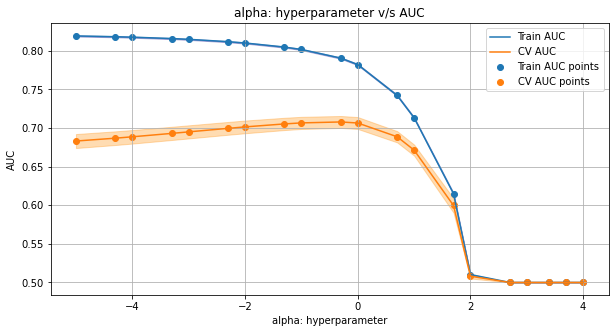

In [36]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
log_alphas =[]
for a in tqdm(alphas):
    #b = math.log(a)
    b = np.log10(a)
    log_alphas.append(b)
plt.figure(figsize=(10,5))
plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

TESTING WITH BEST HYPERPARAMETER VALUE ON SET 1

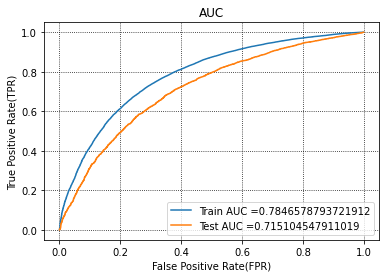

In [37]:
from sklearn.metrics import roc_curve, auc
mnb_bow = MultinomialNB(alpha = bestAlpha_1,class_prior=[0.5, 0.5])
mnb_bow.fit(x_train_onehot_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
# y_train_pred = batch_predict(mnb_bow_testModel, x_train_onehot_bow)
y_train_pred=mnb_bow.predict_proba(x_train_onehot_bow)[:,1]
# y_test_pred = batch_predict(mnb_bow, x_test_onehot_bow)
y_test_pred=mnb_bow.predict_proba(x_test_onehot_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

In [38]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
def predict(proba, threshould, fpr, tpr):
    threshold = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(threshold,3))
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

SET 1 Confusion Matrix: Train

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.5155067624128643 for threshold 0.449
[[ 8589  3473]
 [18754 49184]]
the maximum value of tpr*(1-fpr) 0.5155067624128643 for threshold 0.449


<AxesSubplot:>

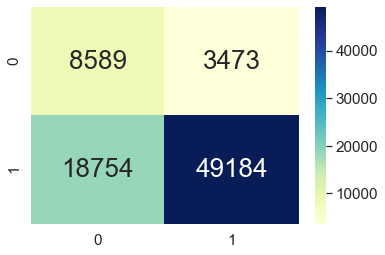

In [39]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))

## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

SET 1 Confusion Matrix: Test

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.44339620707179445 for threshold 0.994
[[ 2671   344]
 [11183  5802]]
the maximum value of tpr*(1-fpr) 0.44339620707179445 for threshold 0.994


<AxesSubplot:>

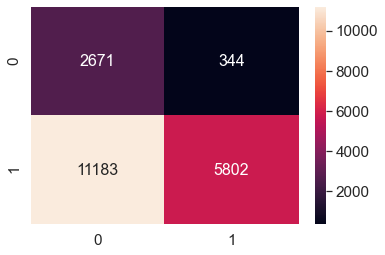

In [40]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

#### Set 2

SET 2 Hyper parameter tuning to find best 'alpha' using GRIDSEARCHCV

In [41]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

from sklearn.model_selection import GridSearchCV
mnb_tfidf = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(mnb_tfidf, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
# clf.fit(x_cv_onehot_tfidf, y_cv)
clf.fit(x_train_onehot_tfidf,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [42]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

bestAlpha_2=clf.best_params_['alpha']
bestScore_2=clf.best_score_
print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_) #clf.best_estimator_.alpha

BEST ALPHA:  0.1  BEST SCORE:  0.6581752635138154


100%|██████████| 20/20 [00:00<00:00, 49902.49it/s]


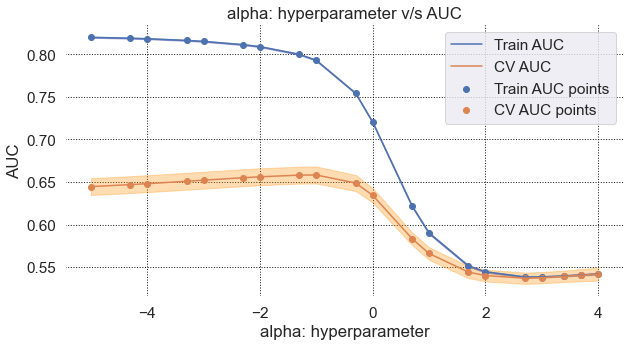

In [43]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
log_alphas =[]
for a in tqdm(alphas):
    #b = math.log(a)
    b = np.log10(a)
    log_alphas.append(b)
plt.figure(figsize=(10,5))
plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

ax = plt.subplot()
ax.scatter(log_alphas, train_auc, label='Train AUC points')
ax.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()


TESTING WITH BEST HYPERPARAMETER VALUE ON SET 2

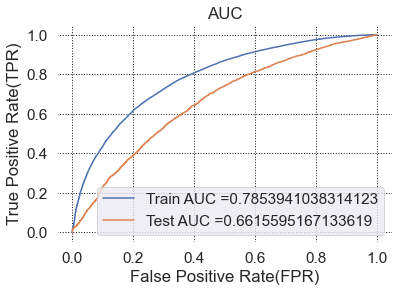

In [44]:
from sklearn.metrics import roc_curve, auc
mnb_tfidf = MultinomialNB(alpha = bestAlpha_2,class_prior=[0.5, 0.5])
mnb_tfidf.fit(x_train_onehot_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
# y_train_pred = batch_predict(mnb_tfidf, x_train_onehot_tfidf)
# y_test_pred = batch_predict(mnb_tfidf, x_test_onehot_tfidf)
y_train_pred=mnb_tfidf.predict_proba(x_train_onehot_tfidf)[:,1]
y_test_pred=mnb_tfidf.predict_proba(x_test_onehot_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

ax = plt.subplot()

auc_set2_train=auc(train_fpr, train_tpr)
auc_set2_test=auc(test_fpr, test_tpr)

# plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
# plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

In [45]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
def predict(proba, threshould, fpr, tpr):
    threshold = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(threshold,3))
    predictions = []
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.5081630078618943 for threshold 0.5
[[ 8649  3413]
 [19791 48147]]
the maximum value of tpr*(1-fpr) 0.5081630078618943 for threshold 0.5


<AxesSubplot:>

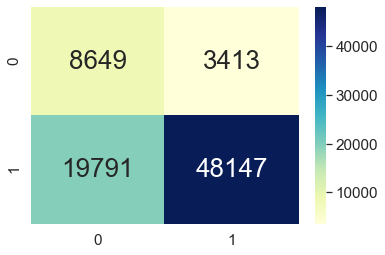

In [46]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)

print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))

## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.38804784828677724 for threshold 0.642
[[ 2437   578]
 [10570  6415]]
the maximum value of tpr*(1-fpr) 0.38804784828677724 for threshold 0.642


<AxesSubplot:>

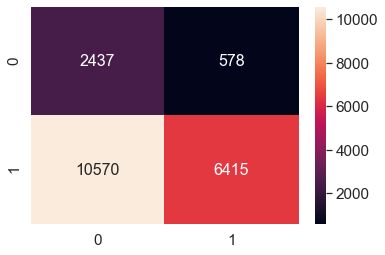

In [47]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

Top 10 important features of negative and positive class from SET 1(BOW)

In [48]:
bow_features_names = []

for feature in vectorizer_sub_cat.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_sub_sub.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_state.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_grade.get_feature_names() :
    bow_features_names.append(feature)

for feature in vectorizer_prefix.get_feature_names() :
    bow_features_names.append(feature)
    
for feature in vectorizer_essay_bow.get_feature_names() :
    bow_features_names.append(feature)
    
for feature in vectorizer_title_bow.get_feature_names() :
    bow_features_names.append(feature)
    
bow_features_names.append("price")

bow_features_names.append("teacher_number_of_previously_posted_projects")

len(bow_features_names)

17587

In [49]:
totalFeatureNamesBow=len(bow_features_names)

In [50]:
x_train_onehot_bow.shape

(80000, 17587)

In [51]:
neg_class_prob_sorted = mnb_bow.feature_log_prob_[0, :].argsort()   #class 0
pos_class_prob_sorted = mnb_bow.feature_log_prob_[1, :].argsort()   #class1
print('Top 10 features from negative class:')
print(np.take(bow_features_names, neg_class_prob_sorted[:10]))
print('-'*50)
print('Top 10 features from positive class:')
print(np.take(bow_features_names, pos_class_prob_sorted[:10]))

Top 10 features from negative class:
['dirt' 'the' 'professionals' 'window' 'rock' 'textbook' 'footsteps'
 'footrest' 'progressive' 'inclusion']
--------------------------------------------------
Top 10 features from positive class:
['paradise' 'transformational' 'correlated' 'games' 'adjective' 'versus'
 'deck' 'grant' '50th' 'supplemented']


In [52]:
tfidf_features_names = []
for feature in vectorizer_sub_cat.get_feature_names():
    tfidf_features_names.append(feature)

for feature in vectorizer_sub_sub.get_feature_names():
    tfidf_features_names.append(feature)

for feature in vectorizer_state.get_feature_names() :
    tfidf_features_names.append(feature)

for feature in vectorizer_grade.get_feature_names() :
    tfidf_features_names.append(feature)

for feature in vectorizer_prefix.get_feature_names() :
    tfidf_features_names.append(feature)
    
for feature in vectorizer_title_tfidf.get_feature_names() :
    tfidf_features_names.append(feature)

for feature in vectorizer_essay_tfidf.get_feature_names() :
    tfidf_features_names.append(feature)
    
tfidf_features_names.append('price')

tfidf_features_names.append('teacher_number_of_previously_posted_projects')

len(tfidf_features_names)

17587

In [53]:
neg_class_prob_sorted = mnb_tfidf.feature_log_prob_[0, :].argsort()   #class 0
pos_class_prob_sorted = mnb_tfidf.feature_log_prob_[1, :].argsort()   #class1
print('Top 10 features from negative class:')
print(np.take(tfidf_features_names, neg_class_prob_sorted[:10]))
print('-'*50)
print('Top 10 features from positive class:')
print(np.take(tfidf_features_names, pos_class_prob_sorted[:10]))

Top 10 features from negative class:
['disappointed' 'shelf' 'vibrate' 'ozobot' 'schedule' 'scheduled' 'owls'
 'ozobots' 'generalization' 'gelli']
--------------------------------------------------
Top 10 features from positive class:
['image' 'tactile' 'refuel' 'preventing' 'counters' 'denham' 'rowdy'
 'accomplishment' 'side' 'bridges']


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [54]:
#Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter: Alpha", "Train AUC", "Test AUC"]
auc_set2_train=auc(train_fpr, train_tpr)
auc_set2_test=auc(test_fpr, test_tpr)

x.add_row(["BOW", "Multinomial Naive Bayes", bestAlpha_1, round(auc_set1_train,2),round(auc_set1_test,2)])
x.add_row(["TF-IDF", "Multinomial Naive Bayes", bestAlpha_2, round(auc_set2_train,2),round(auc_set2_test,2)])

print(x)

+------------+-------------------------+-----------------------+-----------+----------+
| Vectorizer |          Model          | Hyperparameter: Alpha | Train AUC | Test AUC |
+------------+-------------------------+-----------------------+-----------+----------+
|    BOW     | Multinomial Naive Bayes |          0.5          |    0.78   |   0.72   |
|   TF-IDF   | Multinomial Naive Bayes |          0.1          |    0.79   |   0.66   |
+------------+-------------------------+-----------------------+-----------+----------+
